# Imports

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # either 3 or 6

from data_generators import *
import utils
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

torch.__version__

'1.8.1'

In [2]:
# setup generators / data loaders for training and validation

# we'll make the training data loader in the training loop,
# since we need to update some of the examples used each epoch
train_gen = TrainGenerator("mouse", "CTCF")

source_val_gen = ValGenerator("mouse", "CTCF")
# using a batch size of 1 here because the generator returns
# many examples in each batch
source_val_data_loader = DataLoader(source_val_gen, batch_size = 1, shuffle = True)

target_val_gen = ValGenerator("human", "CTCF")
target_val_data_loader = DataLoader(target_val_gen, batch_size = 1, shuffle = True)

1365


# Model Training And Evaluation

In [3]:
class BasicModel(torch.nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        self.input_seq_len = 500
        num_conv_filters = 240
        lstm_hidden_units = 32
        fc_layer1_units = 1024
        fc_layer2_units = 512
        
        # Defining the layers to go into our model
        # (see the forward function for how they fit together)
        self.conv = torch.nn.Conv1d(4, num_conv_filters, kernel_size=20, padding=0)
        self.relu = torch.nn.ReLU()

        # We'll store performance metrics during training in these lists
        self.train_loss_by_epoch = []
        self.source_val_loss_by_epoch = []
        self.source_val_auprc_by_epoch = []
        self.target_val_loss_by_epoch = []
        self.target_val_auprc_by_epoch = []

        # We'll record the best model we've seen yet each epoch
        self.best_state_so_far = self.state_dict()
        self.best_auprc_so_far = 1

    def forward(self, X):
        return (self.conv(X))
        
    def validation(self, data_loader):
        # only run this within torch.no_grad() context!
        losses = []
        preds = []
        labels = []
        for seqs_onehot_batch, labels_batch in data_loader:
            # push batch through model, get predictions, calculate loss
            preds_batch = self(seqs_onehot_batch.squeeze().cuda())
            labels_batch = labels_batch.squeeze()
            loss_batch = self.loss(preds_batch, labels_batch.cuda())
            losses.append(loss_batch.item())

            # storing labels + preds for auPRC calculation later
            labels.extend(labels_batch.detach().numpy())  
            preds.extend(preds_batch.cpu().detach().numpy())
            
        return np.array(losses), np.array(preds), np.array(labels)

    def convolve(self, data_loader):
        # only run this within torch.no_grad() context!

        # DEBUG
        for seqs_onehot_batch, labels_batch in data_loader:
            print('seqs_onehot_batch:',seqs_onehot_batch.shape)
            print('labels_batch:', labels_batch.shape)
            break
            
        features = []
        for seqs_onehot_batch, labels_batch in data_loader:
            # push batch through model, get predictions, calculate loss
            features_batch = self(seqs_onehot_batch.squeeze().cuda())
            print(features_batch.shape)
            # storing labels + preds for auPRC calculation later
            features.extend(features_batch.cpu().detach().numpy())
#             features.extend(features_batch.cpu().detach().numpy())
        features_all = np.array(features)
        print('features:',features_all.shape)
        return features_all # maybe hold off on converting to numpy to run torch.cov on the gpu?
    
    def loader_to_generator(self, data_loader):
        for batch in data_loader:
            yield batch
    
    def get_cov(self, data_loader, nbatch=100):
        """
        seqs_onehot_batch : (1, batchsize, input_seq_len) [1, 1000, 4, 500]
        convolved_batch : (batchsize, num_conv_filters, input_seq_len - padding) [1000, 240, 481]
        labels_batch : (1, batchsize) [1, 1000]
        cov_batch : ()
        """
        covariances = []
        generator = self.loader_to_generator(data_loader)
        for i in range(nbatch):
            seqs_onehot_batch, labels_batch = next(generator)
            # push batch through model, get predictions, calculate loss
            convolved_batch = self(seqs_onehot_batch.squeeze().cuda())
            cov_batch = np.cov(torch.max(convolved_batch, 2).values.T.cpu().detach().numpy())
            covariances.append(cov_batch)
        print(f'cov of batch {i-nbatch+1} to {i+1}')
        return covariances

In [4]:
model = BasicModel()
model.cuda()
print('Getting covariances for source and target...')
src_cov0 = model.get_cov(source_val_data_loader)
src_cov1 = model.get_cov(source_val_data_loader)
tgt_cov0 = model.get_cov(target_val_data_loader)
tgt_cov1 = model.get_cov(target_val_data_loader)
model.cpu()


Getting covariances for source and target...
cov of batch 0 to 100
cov of batch 0 to 100
cov of batch 0 to 100
cov of batch 0 to 100


BasicModel(
  (conv): Conv1d(4, 240, kernel_size=(20,), stride=(1,))
  (relu): ReLU()
)

In [6]:
norm_diff = lambda A, B: [np.linalg.norm(a - b) for (a,b) in zip(A,B)]

mm = norm_diff(src_cov0, src_cov1)
# print(mm)
hm = norm_diff(src_cov0, tgt_cov0)
hh = norm_diff(tgt_cov0, tgt_cov1)
same = norm_diff(tgt_cov0, tgt_cov0)
len(tgt_cov1)

100

In [7]:
def get_conv_filters(first, second):
#     src_cov0, tgt_cov0
#     src_cov1, tgt_cov1 (2nd batch)
    norm_diff = lambda A, B: [np.abs(a - b) for (a,b) in zip(A,B)]
    a = norm_diff(first, second)
#     print(a)
    mxm = a[0][0][0]
    sol = []
    for x in a:
        r = 0
        for y in x:
            r += 1
            c = 0
            for z in y:
                c += 1
                if z > mxm and c != r:
                    print(z, r, c)
                    mxm = z
                    current = [r, c]
        sol.append(current)
    return sol
#         print(x, x.shape)
#         y = max(x)
#         print('y', y)
#         [b, c] = find(x==y)
#         print(b)
#     for argmax(norm_diff)
    

In [8]:
print(get_conv_filters(src_cov0, tgt_cov0))

0.0010614227978413627 1 8
0.0012787100967042845 1 134
0.001473694730517875 5 115
0.0019333227528645562 6 40
0.0020820605894279766 23 237
0.0025105248692933765 78 170
0.002819291001709281 78 237
0.002994904467489385 115 237
0.00362380436673034 170 229
0.0036914136278066887 170 229
0.00409084866164753 170 237
0.004348053816750737 170 229
0.004458256049004624 170 229
0.004481234460351122 170 229
0.004723527660906041 170 237
0.004803111776171495 170 229
0.005136398360022255 170 229
0.005161311754171217 170 229
[[78, 237], [170, 229], [170, 229], [170, 229], [170, 237], [170, 237], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 237], [170, 237], [170, 237], [170, 237], [170, 237], [170, 237], [170, 237], [170, 237], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 229], [170, 22

(array([ 1.,  6.,  1.,  6.,  8., 10., 15., 11., 11.,  7.,  1., 13.,  3.,
         2.,  2.,  2.,  0.,  0.,  0.,  1.]),
 array([0.09313191, 0.09389735, 0.09466278, 0.09542822, 0.09619366,
        0.09695909, 0.09772453, 0.09848997, 0.0992554 , 0.10002084,
        0.10078628, 0.10155172, 0.10231715, 0.10308259, 0.10384803,
        0.10461346, 0.1053789 , 0.10614434, 0.10690977, 0.10767521,
        0.10844065]),
 <BarContainer object of 20 artists>)

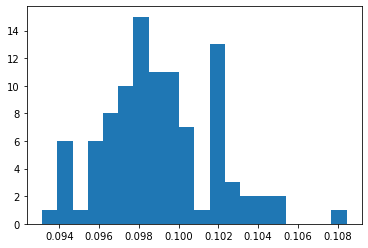

In [9]:
plt.hist(hm, bins=20)

In [ ]:
plt.hist(mm, bins=20)

In [ ]:
plt.hist(hh, bins=20)

In [ ]:
plt.hist(same, bins=20)

In [ ]:
print(f'human-human ~ N({np.mean(hh)}, {np.std(hh)}^2)')
print(f'human-mouse ~ N({np.mean(hm)}, {np.std(hm)}^2)')
print(f'mouse-mouse ~ N({np.mean(mm)}, {np.std(mm)}^2)')